# Inférence & eval

In [1]:
import torch

thresholds   = [0.1, 1, 2.5]  # series of thresholds (unit: mm/h)
thresholds   = [100*k/12 for k in thresholds]
scores = torch.load('lastrun/scores.pt')

/local/bereziat/opt/conda/env/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


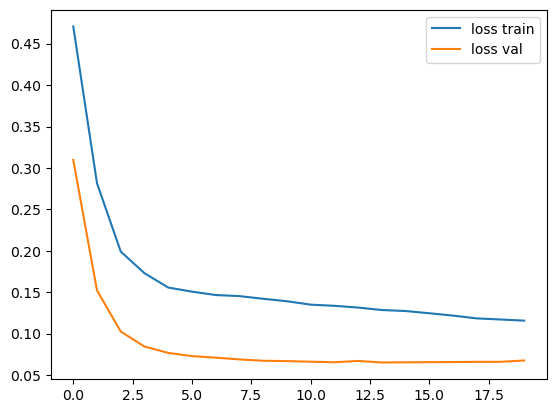

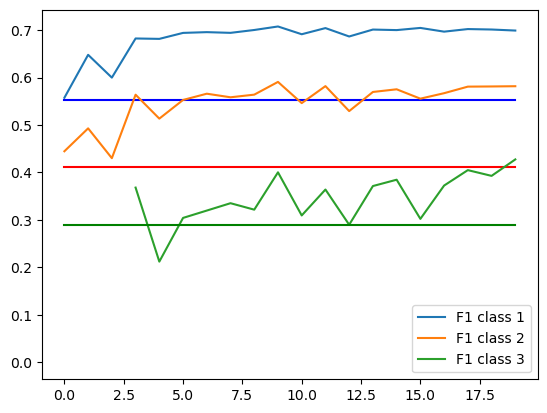

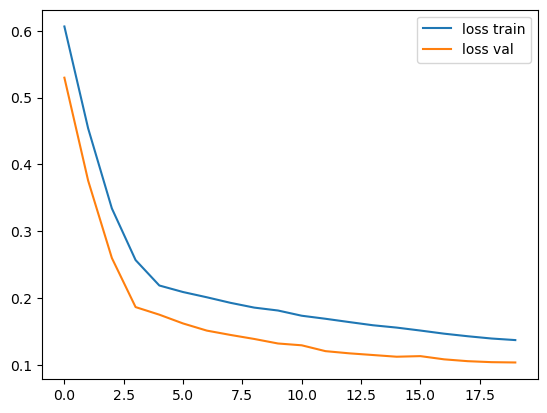

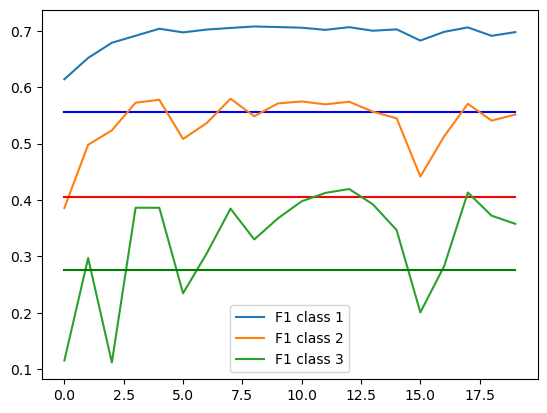

In [14]:
import matplotlib.pyplot as plt

def plot_scores( scores, save=None):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1_pred']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    if save:
        plt.savefig(save)
    else:
        plt.show()
plot_scores(scores)
plot_scores(torch.load('runs/2023-07-21 11:07:38.161407/scores.pt'))

In [3]:
# get train, val and test datasets
from loader.meteonet import MeteonetDataset
from tqdm import tqdm
from loader.filesets import filesets_bouget21

train_files, val_files, test_files = filesets_bouget21('data/rainmaps')

# datasets only rainmaps
train_ds = MeteonetDataset( train_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/train-wind.npz', tqdm=tqdm)
val_ds   = MeteonetDataset( val_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/val-wind.npz', tqdm=tqdm)
test_ds  = MeteonetDataset( test_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/test-wind.npz', tqdm=tqdm)

# dataset rainmaps and windmaps
rain_val_ds = MeteonetDataset( val_files, 12, 18, 12, cached=f'data/val.npz', tqdm=tqdm)
rain_test_ds = MeteonetDataset( test_files, 12, 18, 12, cached=f'data/test.npz', tqdm=tqdm)

# important !
val_ds.norm_factor = train_ds.norm_factor
test_ds.norm_factor = train_ds.norm_factor
rain_val_ds.norm_factor = train_ds.norm_factor
rain_test_ds.norm_factor = train_ds.norm_factor

val_ds.params['U_moments'] = train_ds.params['U_moments']
val_ds.params['V_moments'] = train_ds.params['V_moments']

test_ds.params['U_moments'] = train_ds.params['U_moments']
test_ds.params['V_moments'] = train_ds.params['V_moments']


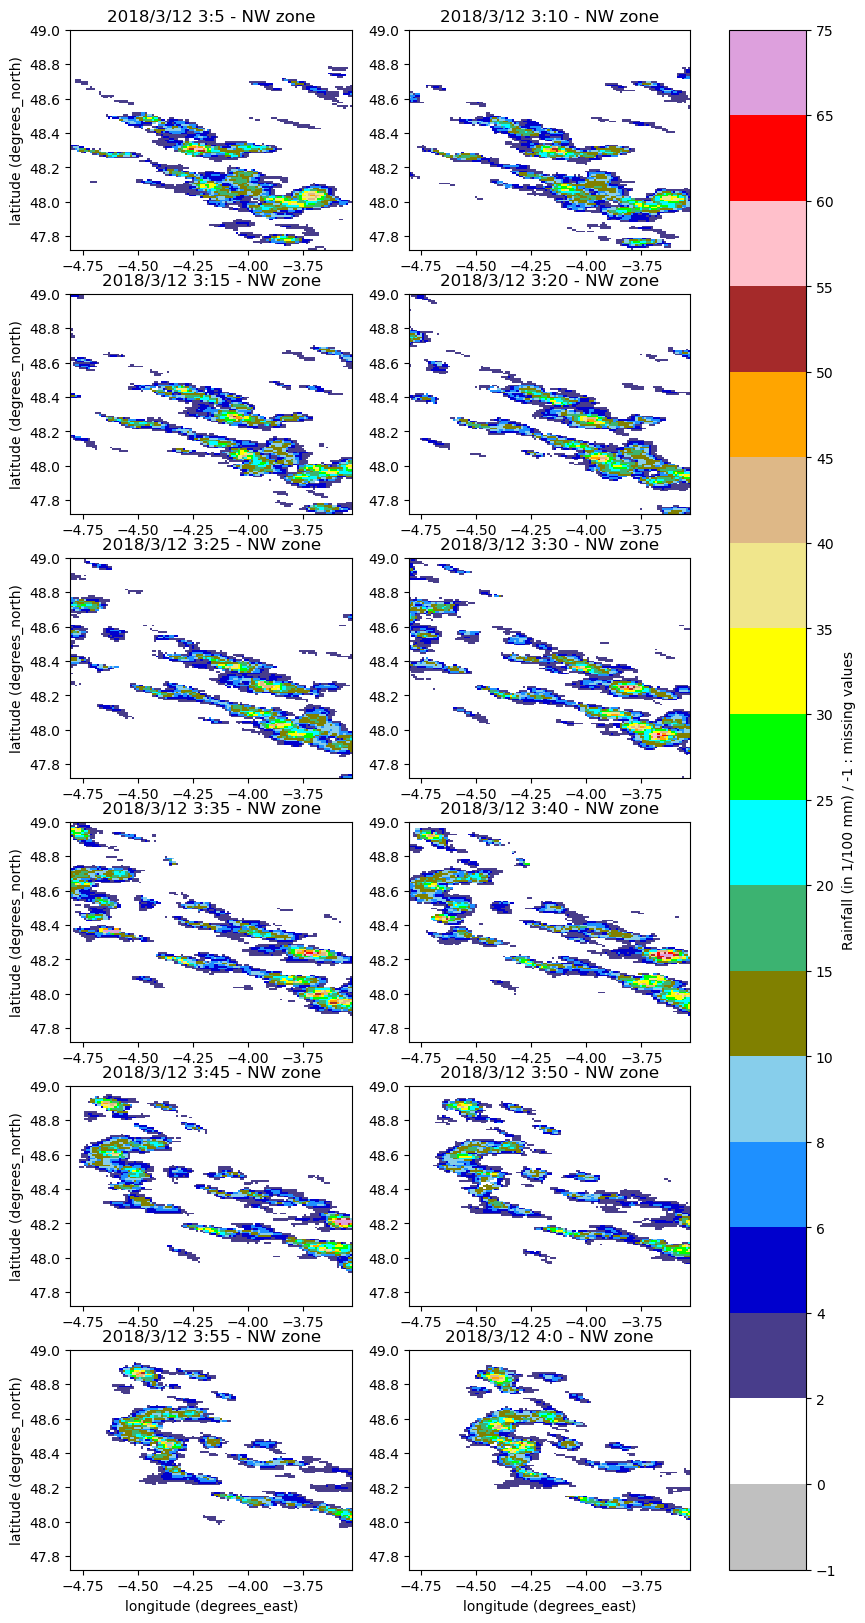

In [4]:
from loader.plots import plot_meteonet_rainmaps
from data.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

train_date = 2017,3,1,12,0 # dans train_ds
val_date = 2018,3,12,3,5 # dans val_ds

plot_meteonet_rainmaps( val_ds, val_date, lon, lat, zone)

In [16]:
from models.unet import UNet

# three models
model_dom_rain = UNet( n_channels= 12, n_classes = 3, bilinear = True)
model_dom_rain.load_state_dict(torch.load('weights/model_dom_30m_rain.pt'))
#model_dom_rain.load_state_dict(torch.load('weights/dernier_rain.pt'))

model_dom = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
model_dom.load_state_dict(torch.load('weights/model_dom_30m_wind.pt'))
#model_dom.load_state_dict(torch.load('weights/dernier_wind.pt'))

model_vinc = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
model_vinc.load_state_dict(torch.load('weights/model_vinc_30m_wind.pt'))

<All keys matched successfully>

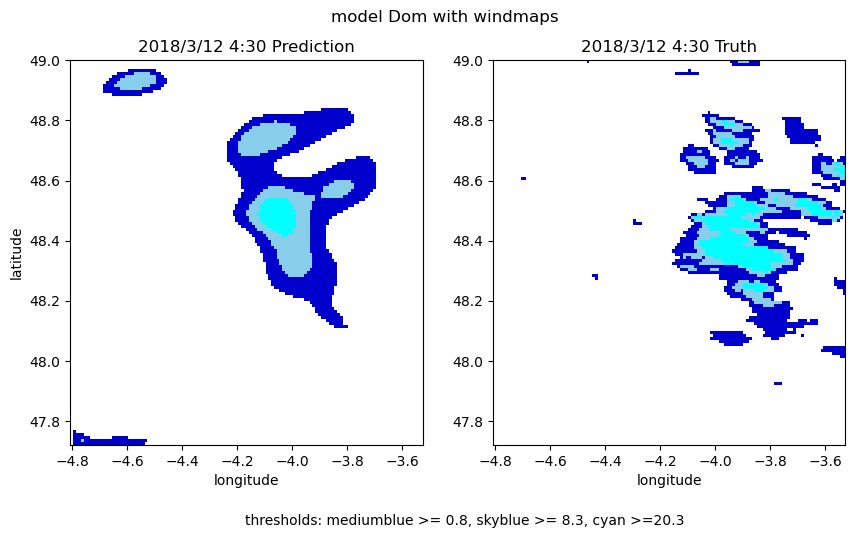

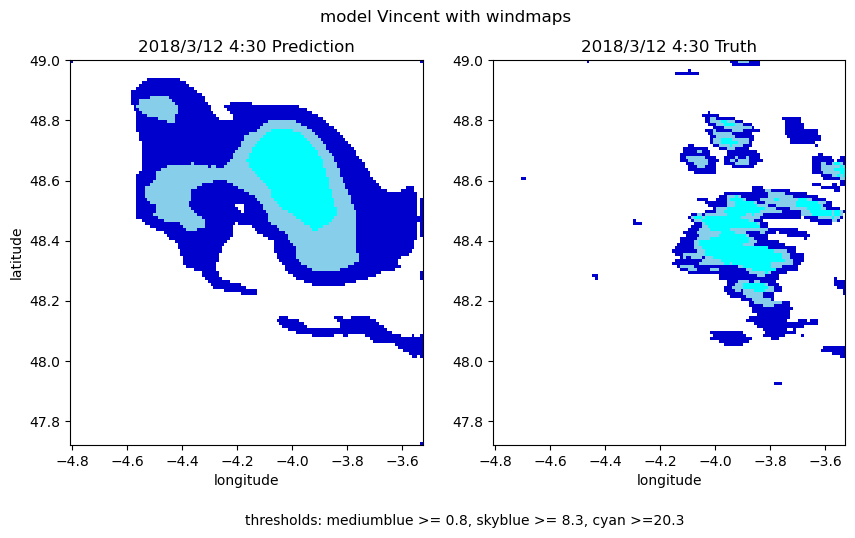

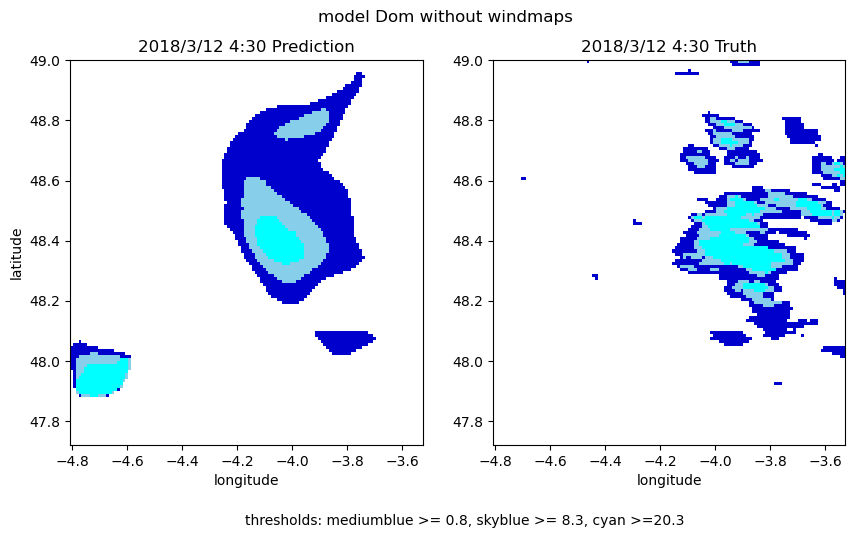

In [17]:
from loader.plots import plot_inference

plot_inference( val_ds, val_date, model_dom, thresholds, lon, lat, zone, 'model Dom with windmaps')
plot_inference( val_ds, val_date, model_vinc, thresholds, lon, lat, zone, 'model Vincent with windmaps')
plot_inference( rain_val_ds, val_date, model_dom_rain, thresholds, lon, lat, zone, 'model Dom without windmaps')


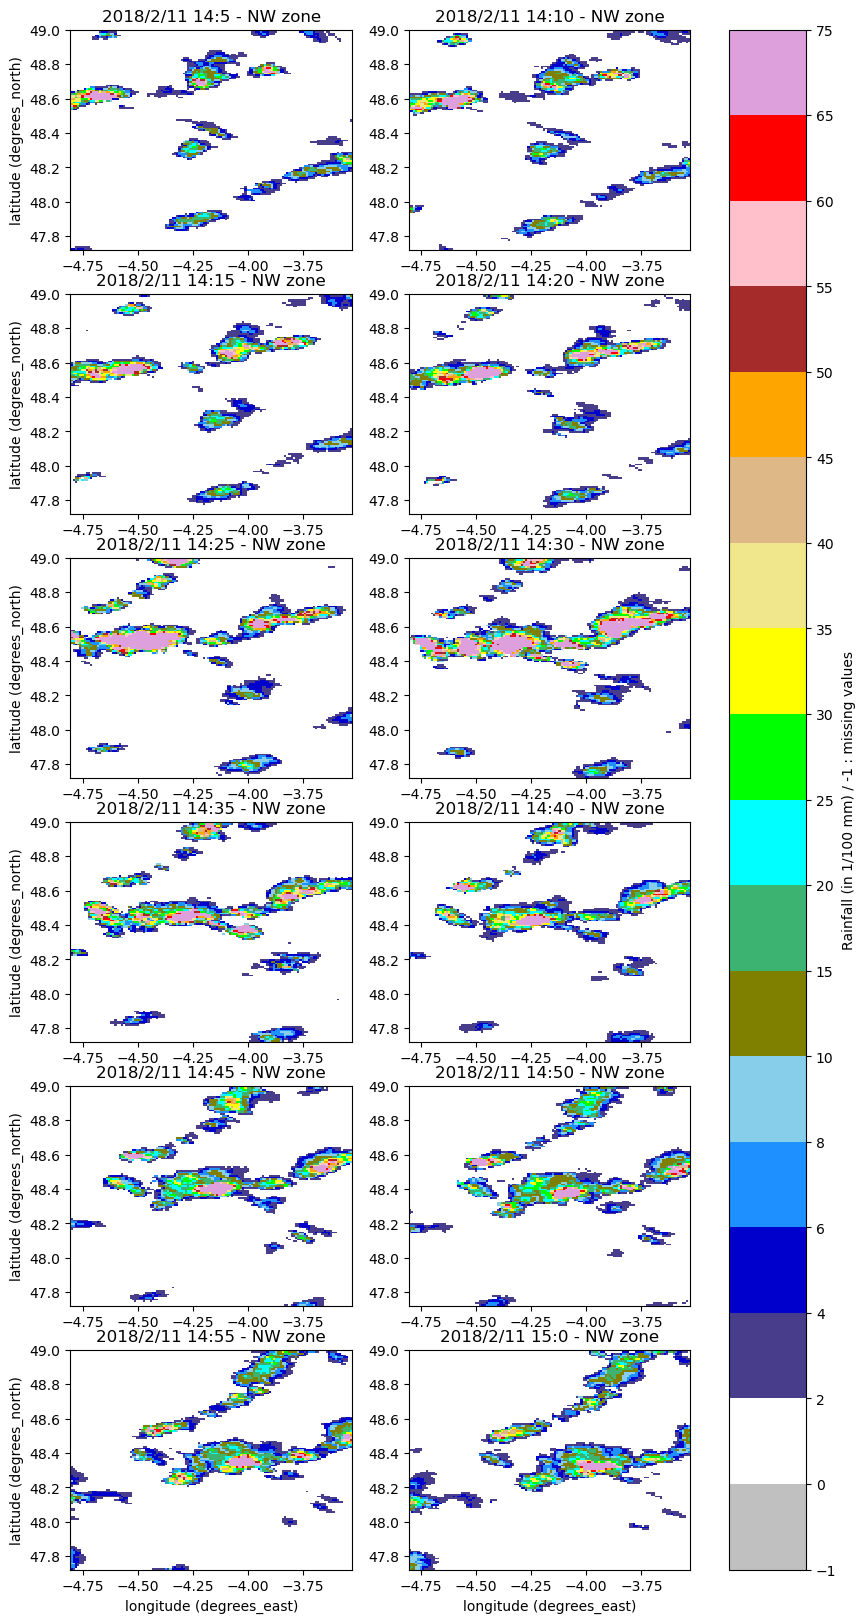

In [7]:
test_date = 2018, 2, 11, 14, 5
plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone)

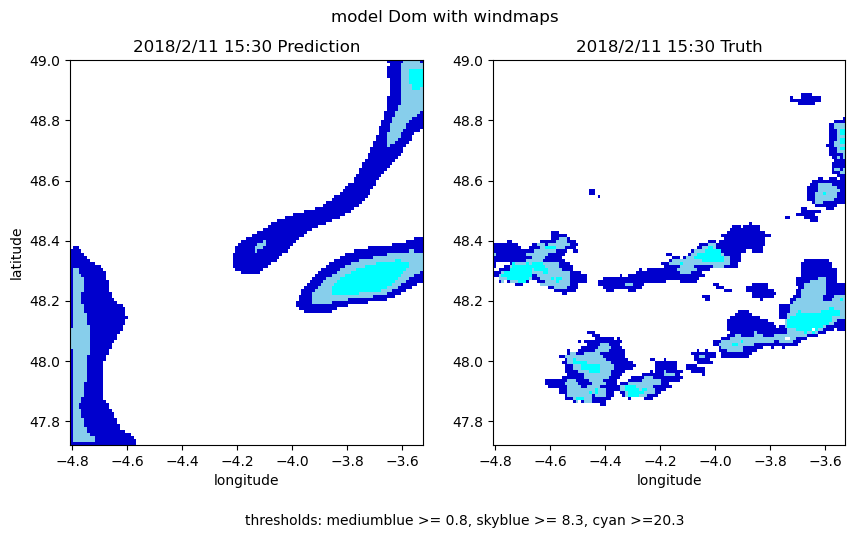

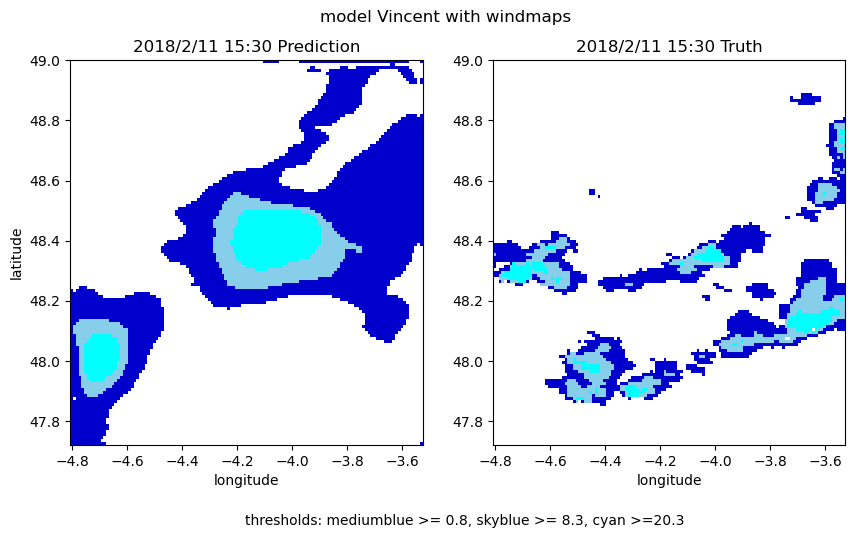

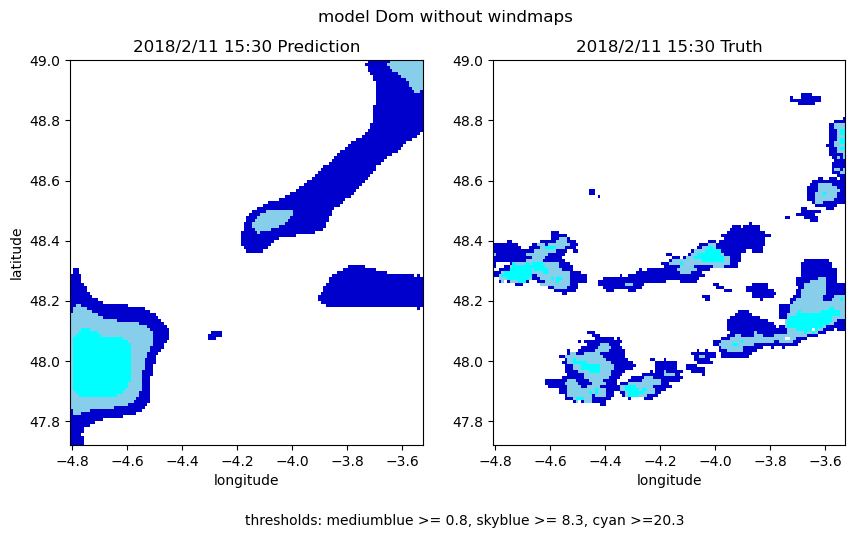

In [18]:
plot_inference( test_ds, test_date, model_dom, thresholds, lon, lat, zone, 'model Dom with windmaps')
plot_inference( test_ds, test_date, model_vinc, thresholds, lon, lat, zone, 'model Vincent with windmaps')
plot_inference( rain_test_ds, test_date, model_dom_rain, thresholds, lon, lat, zone, 'model Dom without windmaps')


In [10]:
import pandas as pd
from loader.utilities import get_item_by_date

def calculate_TPFPFN( pred, true):
    """ BCNM*BCNM
    """
    diff = 2*pred - 1*true
    return torch.cat((torch.sum(diff==1,dim=(0,2,3)), # TP
                      torch.sum(diff==2,dim=(0,2,3)), # FP
                      torch.sum(diff==-1,dim=(0,2,3)  # FN
                    ))).reshape(3,-1)

def calculate_scores( TPFPFN):
    TP, FP, FN = TPFPFN
    precis = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precis*recall/(precis+recall) # if precis>0 or recall>0 else np.nan
    return precis,recall,f1

def score_inference(ds, date, model):
    """ """
    item = ds[get_item_by_date(ds, date)]
    with torch.no_grad():
        y = model(item['inputs'].unsqueeze(0))
    return calculate_TPFPFN(torch.sigmoid(y)>.5, item['target'])

item = test_ds[get_item_by_date(test_ds, test_date)]
with torch.no_grad():
    y = model_dom(item['inputs'].unsqueeze(0))

pred = (torch.sigmoid(y)>.5)
true = torch.cat([item['target'].unsqueeze(0)>t for t in thresholds], dim=0).unsqueeze(0)
sc = calculate_TPFPFN(pred,true)
df2 = pd.DataFrame( sc, columns=['C1','C2','C3'], index=['TP','FP','FN'])
df2

,C1,C2,C3
TP,451,36,0
FP,2200,854,230
FN,2206,1013,270


In [ ]:
a = (torch.sigmoid(y)>.5).squeeze(0)
b = torch.cat([item['target'].unsqueeze(0)>t for t in thresholds], dim=0)
plt.imshow(a[0]&b[0])